In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [86]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [87]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [88]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [89]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [90]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [91]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [92]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [93]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [94]:
from shapely.geometry import LineString, Polygon, Point

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [95]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Generate Intermediate Point

In [96]:
def create_polygon(points):
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    return obstacle

In [97]:
def is_obstacle_free(line, obstacles):
    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            return False
    return True

In [98]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.3
    increment = 0.3
    limit = 2.5

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        # if not left_side.intersects(target_obs):
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        # if not right_side.intersects(target_obs):
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        # if not up_side.intersects(target_obs):
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        # if not down_side.intersects(target_obs):
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

In [99]:
def adv_route(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)-1):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            if intermediate_point == None:
                return route, "fail"
            ans_route.append(route[i])
            ans_route.append(intermediate_point)
            ans_route.append(route[i+1])
            ans_route.append(intermediate_point)
        else:
            ans_route.append(route[i])
            ans_route.append(route[i+1])

    ans_route.append(dp)
    return ans_route, "pass"

## Creation of New DP

In [100]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if ls2[i] == pt1:
            ls2[i] = pt2

    return ls2

In [101]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [102]:
def calculate_obstacle_free_dp(delivery_loc, obstacles, dp):
    # Create Shapely objects for efficient geometric calculations
    delivery_points = [Point(x, y) for x, y in delivery_loc]
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}

    # Initialize potential DP locations (covering the delivery point area)
    min_x = dp[0] - 1.0
    max_x = dp[0] + 1.0
    min_y = dp[1] - 1.0
    max_y = dp[1] + 1.0

    potential_dps = {}
    for x in frange(min_x, max_x, 0.2):
        for y in frange(min_y, max_y, 0.2):
            potential_dps[x,y] = {
                'route' : [],
                'distance' : 0
            }

    # Evaluate each potential DP and filter out those obstructed by obstacles
    for each_dp, value in potential_dps.items():
        first_route = create_route(delivery_loc, each_dp)
        last_route,msg = adv_route(first_route,each_dp,obstacles)
        if msg == 'pass':
            distance = total_dist(last_route)
        else:
            distance = float('inf')
        potential_dps[each_dp]['route'] = last_route
        potential_dps[each_dp]['distance'] = distance

    answer = min(potential_dps, key = lambda x : potential_dps[x]['distance'])

    return answer,potential_dps[answer]['route'],potential_dps[answer]['distance']

## Remove delivary points that are in the obstacles

In [103]:
def remove_obstacle(delivary_loc, obstacles):
    obstacle_polygon = {obs_id : create_polygon(obs) for obs_id, obs in obstacles.items()}
    delivary_point = [Point([a,b]) for a,b in delivary_loc]
    final_point = []
    
    for point in delivary_point:
        flag = True
        for obs_id, obs in obstacle_polygon.items():
            if (point.intersects(obs)):
                flag = False
                break
        if flag:
            final_point.append([point.x, point.y])
    return final_point

## Main

In [104]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 30

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

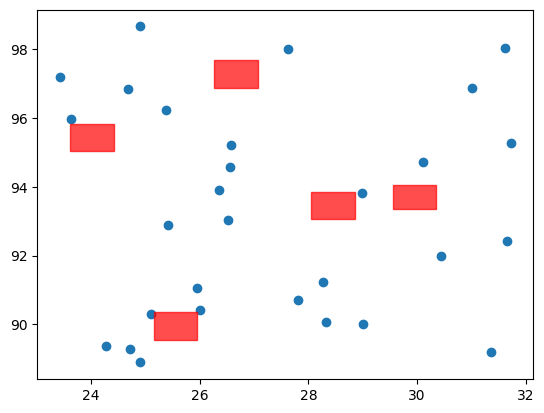

In [105]:
# creating obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.85]],
    1 : [[25.15, 89.55],[25.95, 90.35]],
    2 : [[26.27, 96.89],[27.07, 97.69]],
    3 : [[23.62, 95.04],[24.42, 95.84]],
    4 : [[29.55, 93.35],[30.35, 94.05]],
}

delivary_loc = remove_obstacle(delivary_loc, obstacles)

primary_plot(delivary_loc, obstacles)

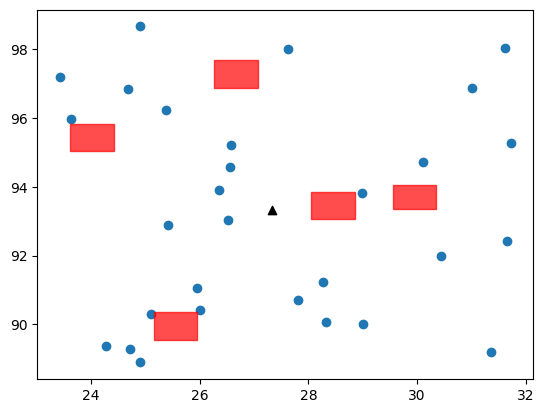

In [106]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [107]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[27.32128084690574, 93.31764122322697] -> [31.356383732846343, 89.18765573884696] -> [27.32128084690574, 93.31764122322697] -> [25.409470410701097, 92.88562767461269] -> [27.32128084690574, 93.31764122322697] -> [28.315844166373918, 90.05635166821742] -> [27.32128084690574, 93.31764122322697] -> [24.90414737079421, 88.88504463816273] -> [27.32128084690574, 93.31764122322697] -> [28.981380770439756, 93.81332537851283] -> [27.32128084690574, 93.31764122322697] -> [25.94474397724588, 91.03988372029843] -> [27.32128084690574, 93.31764122322697] -> [24.90739824132919, 98.66895604714006] -> [27.32128084690574, 93.31764122322697] -> [31.725079565651036, 95.28079980597943] -> [27.32128084690574, 93.31764122322697] -> [31.64654581635744, 92.41739845700252] -> [27.32128084690574, 93.31764122322697] -> [28.268783114315887, 91.2402921194805] -> [27.32128084690574, 93.31764122322697] -> [24.714697780649683, 89.29038367018167] -> [27.32128084690574, 93.31764122322697] -> [26.349155744676857, 93.9207

Initial Distance : 214.5569079561025


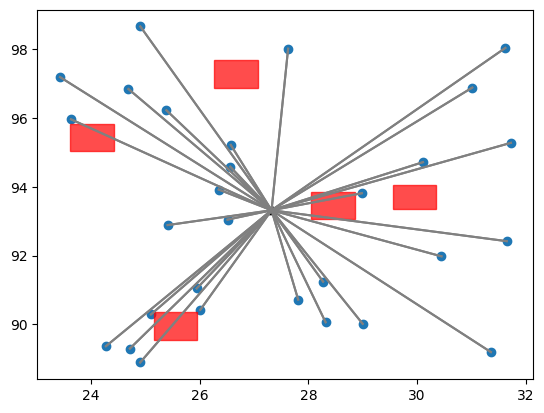

In [108]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

--------------------------------------------------
Obstacle avoidance =>
Dp = [27.32128084690574, 93.31764122322697]
Route = [[27.32128084690574, 93.31764122322697], [31.356383732846343, 89.18765573884696], [27.32128084690574, 93.31764122322697], [25.409470410701097, 92.88562767461269], [27.32128084690574, 93.31764122322697], [28.315844166373918, 90.05635166821742], [27.32128084690574, 93.31764122322697], [24.584876793438937, 89.94999999999999], [24.90414737079421, 88.88504463816273], [24.584876793438937, 89.94999999999999], [27.32128084690574, 93.31764122322697], [28.450000000000003, 94.25466202060491], [28.981380770439756, 93.81332537851283], [28.450000000000003, 94.25466202060491], [27.32128084690574, 93.31764122322697], [25.94474397724588, 91.03988372029843], [27.32128084690574, 93.31764122322697], [24.90739824132919, 98.66895604714006], [27.32128084690574, 93.31764122322697], [28.282739638886316, 94.04624756969896], [31.725079565651036, 95.28079980597943], [28.282739638886316, 94.

Relocation of DP =>
Dp = (26.9213, 93.3176)
Route = [(26.9213, 93.3176), [31.356383732846343, 89.18765573884696], (26.9213, 93.3176), [25.409470410701097, 92.88562767461269], (26.9213, 93.3176), [28.315844166373918, 90.05635166821742], (26.9213, 93.3176), [24.788783733514435, 89.94999999999999], [24.90414737079421, 88.88504463816273], [24.788783733514435, 89.94999999999999], (26.9213, 93.3176), [28.450000000000003, 94.28545712337424], [28.981380770439756, 93.81332537851283], [28.450000000000003, 94.28545712337424], (26.9213, 93.3176), [25.94474397724588, 91.03988372029843], (26.9213, 93.3176), [24.90739824132919, 98.66895604714006], (26.9213, 93.3176), [27.8370183000994, 93.81443752101089], [31.725079565651036, 95.28079980597943], [27.8370183000994, 93.81443752101089], (26.9213, 93.3176), [27.887979267425393, 93.07628628314066], [31.64654581635744, 92.41739845700252], [27.887979267425393, 93.07628628314066], (26.9213, 93.3176), [28.268783114315887, 91.2402921194805], (26.9213, 93.3176)

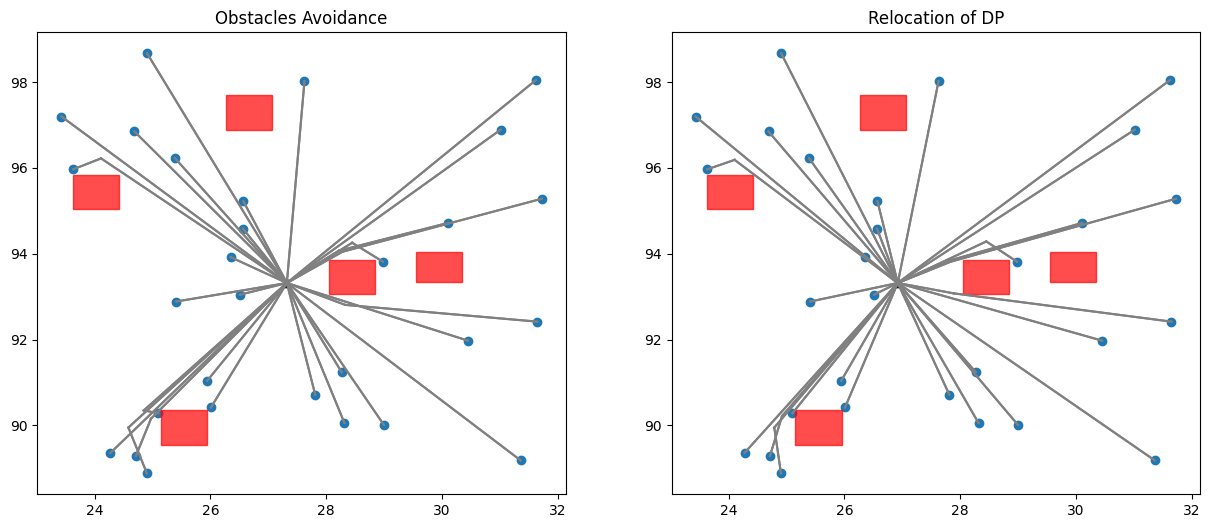

Optimal dp : (26.9213, 93.3176)
Optimal route : [(26.9213, 93.3176), [31.356383732846343, 89.18765573884696], (26.9213, 93.3176), [25.409470410701097, 92.88562767461269], (26.9213, 93.3176), [28.315844166373918, 90.05635166821742], (26.9213, 93.3176), [24.788783733514435, 89.94999999999999], [24.90414737079421, 88.88504463816273], [24.788783733514435, 89.94999999999999], (26.9213, 93.3176), [28.450000000000003, 94.28545712337424], [28.981380770439756, 93.81332537851283], [28.450000000000003, 94.28545712337424], (26.9213, 93.3176), [25.94474397724588, 91.03988372029843], (26.9213, 93.3176), [24.90739824132919, 98.66895604714006], (26.9213, 93.3176), [27.8370183000994, 93.81443752101089], [31.725079565651036, 95.28079980597943], [27.8370183000994, 93.81443752101089], (26.9213, 93.3176), [27.887979267425393, 93.07628628314066], [31.64654581635744, 92.41739845700252], [27.887979267425393, 93.07628628314066], (26.9213, 93.3176), [28.268783114315887, 91.2402921194805], (26.9213, 93.3176), [2

In [109]:
THRESHOLD = initial_dist + (initial_dist*0.03)

if(detect_obstacle(initial_route, obstacles)):

    # obstacle avoidance
    temp_route = initial_route.copy()
    new_route, msg = adv_route(temp_route, initial_dp, obstacles)
    if msg == "pass":
        new_dist = total_dist(new_route)
    else:
        new_dist = float('inf')
    print("-"*50)
    print("Obstacle avoidance =>")
    print("Dp =",initial_dp)
    print("Route =",new_route)
    print("Total distance =",new_dist)
    print("-"*50)

    # locate new dp
    new_dp,final_route,final_dist = calculate_obstacle_free_dp(delivary_loc, obstacles, initial_dp)

    print("Relocation of DP =>")
    print("Dp =",new_dp)
    print("Route =",final_route)
    print("Total distance =",final_dist)
    print("-"*50)

    # comparison
    if final_dist < new_dist:
        optimal_dp = new_dp
        optimal_route = final_route
    else:
        optimal_dp = initial_dp
        optimal_route = new_route

    # visual representation
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plot_initial_route(initial_dp,delivary_loc, obstacles, new_route, "Obstacles Avoidance")
    plt.subplot(1,2,2)
    plot_initial_route(new_dp,delivary_loc, obstacles, final_route, "Relocation of DP")
    plt.show()
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

## Result

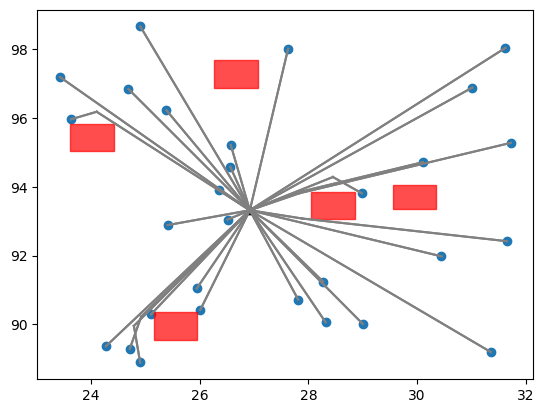

In [110]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)

<font color="red">How to select range and interval in the "Relocation of dp section"</font>

## Hold

In [111]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
        if len(intersections) > 0:
            target_obs = obstacle
            break

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        distances[inter] = dist_to_a

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    interval = 0.3

    while interval < 2.5:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if not left_side.intersects(target_obs):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if not right_side.intersects(target_obs):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if not up_side.intersects(target_obs):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if not down_side.intersects(target_obs):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += 0.3

    return None

In [112]:
def calculate_obstacle_free_dp(delivery_loc, obstacles):
    # Create Shapely objects for efficient geometric calculations
    delivery_points = [Point(x, y) for x, y in delivery_loc]
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}

    # Initialize potential DP locations (covering the delivery point area)
    min_x, max_x, min_y, max_y = float('inf'), float('-inf'), float('inf'), float('-inf')
    for point in delivery_points:
        min_x = min(min_x, point.x)
        max_x = max(max_x, point.x)
        min_y = min(min_y, point.y)
        max_y = max(max_y, point.y)

    potential_dps = []
    for x in frange(min_x, max_x, 0.5):
        for y in frange(min_y, max_y, 0.5):
            potential_dps.append([x, y])

    # Evaluate each potential DP and filter out those obstructed by obstacles
    accessible_dps = []
    for dp in potential_dps:
        dp_point = Point(*dp)
        is_reachable = True
        for obstacle_id, obstacle in obstacle_polygons.items():
            # Check if any obstacle intersects the straight line from dp to each delivery point
            for delivery_point in delivery_points:
                line = LineString([dp_point, delivery_point])
                if line.intersects(obstacle):
                    is_reachable = False
                    break
            if not is_reachable:  # Early break if obstructed by any obstacle
                break
        if is_reachable:
            accessible_dps.append(dp)

    # Choose the DP with minimum average distance to delivery points (for efficiency)
    if not accessible_dps:
        return calculate_dp(delivery_loc), "fail"
        # raise ValueError("No obstacle-free DP location found!")

    best_dp = accessible_dps[0]
    min_avg_distance = float('inf')
    for dp in accessible_dps:
        total_distance = 0
        for delivery_point in delivery_points:
            total_distance += euc_distance(dp, [delivery_point.x, delivery_point.y])
        avg_distance = total_distance / len(delivery_points)
        if avg_distance < min_avg_distance:
            min_avg_distance = avg_distance
            best_dp = dp

    return best_dp, "pass"